In [2]:
!pip install pmdarima --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 15.3 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima import auto_arima

In [5]:
raw_path="/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv"
df = pd.read_csv(raw_path, encoding="utf-8-sig")

In [6]:
report = []   # to store documentation notes

report.append("DATA CLEANING REPORT\n")
report.append("---------------------\n")
report.append(f"Original file loaded: {raw_path}\n")
report.append(f"Initial shape: {df.shape}\n\n")
print(df.columns.tolist())

['Date', 'Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']


In [7]:
invalid_dates = df['Date'].isna().sum()
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y", errors='coerce')

report.append(f"Converted Date column to datetime.\n")
report.append(f"Invalid date entries converted to NaT: {invalid_dates}\n\n")

df = df.dropna(subset=['Date'])
df = df.sort_values('Date').reset_index(drop=True)


In [8]:
before = len(df)
df = df.drop_duplicates()
after = len(df)

report.append(f"Duplicates removed: {before - after}\n\n")

In [9]:
missing_before = df.isnull().sum()

report.append("Missing values before cleaning:\n")
report.append(str(missing_before) + "\n\n")

numeric_cols = ['Local Route', 'Light Rail', 'Peak Service',
                'Rapid Route', 'School', 'Other']

df = df.set_index('Date')
df[numeric_cols] = df[numeric_cols].interpolate(method='time')
df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')
df = df.reset_index()

missing_after = df.isnull().sum()
report.append("Missing values after cleaning:\n")
report.append(str(missing_after) + "\n\n")

/tmp/ipython-input-2079270687.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')


In [10]:
negatives_info = {}

for col in numeric_cols:
    neg_values = (df[col] < 0).sum()
    negatives_info[col] = neg_values
    df[col] = df[col].clip(lower=0)

report.append("Negative values found (fixed using clip lower=0):\n")
report.append(str(negatives_info) + "\n\n")


In [13]:
output_dir = "/mnt/data/cleaned_data"
os.makedirs(output_dir, exist_ok=True)

cleaned_path = f"{output_dir}/cleaned_transport_data.csv"
df.to_csv(cleaned_path, index=False)

report.append(f"Cleaned dataset saved at: {cleaned_path}\n\n")

In [14]:
report_path = f"{output_dir}/data_cleaning_report.txt"

with open(report_path, "w") as f:
    f.writelines(report)

print("Data cleaning completed.")
print(f"Cleaned CSV saved at: {cleaned_path}")
print(f"Documentation saved at: {report_path}")

Data cleaning completed.
Cleaned CSV saved at: /mnt/data/cleaned_data/cleaned_transport_data.csv
Documentation saved at: /mnt/data/cleaned_data/data_cleaning_report.txt


In [15]:
# Load the cleaned dataset
cleaned_path = "/mnt/data/cleaned_data/cleaned_transport_data.csv"
df = pd.read_csv(cleaned_path)

# Convert Date to datetime and set index
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").sort_index()

print("Loaded cleaned dataset:")
print(df.head())

Loaded cleaned dataset:
            Local Route  Light Rail  Peak Service  Rapid Route  School  Other
Date                                                                         
2019-07-01        15987        9962           407        21223    3715    0.0
2019-07-02        16895       10656           409        21715    3993    0.0
2019-07-03        16613       10658           427        22025    3638    0.0
2019-07-04        16604       10445           437        21868    3576    0.0
2019-07-05        16040       10532           400        20697    2856    0.0


In [16]:
service = "Local Route"     # <=== Change this for different forecasts
ts = df[service]

print(f"\nForecasting for: {service}")


Forecasting for: Local Route


In [17]:
train = ts.iloc[:-30]
test = ts.iloc[-30:]

print("\nTrain size:", train.shape)
print("Test size:", test.shape)



Train size: (1888,)
Test size: (30,)


In [27]:
#AUTO-SARIMA MODEL FITTING
print("\nRunning Auto-ARIMA (SARIMA mode)...")

model = auto_arima(
    train,
    seasonal=True,
    m=7,                    # Weekly seasonality cycle
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

print("\nBest ARIMA order:", model.order)
print("Best Seasonal order:", model.seasonal_order)


Running Auto-ARIMA (SARIMA mode)...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=35196.880, Time=10.30 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=38082.813, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=inf, Time=8.56 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=36793.990, Time=4.05 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=38080.814, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=36327.652, Time=3.69 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=8.62 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=15.71 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=35178.673, Time=14.89 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=35980.231, Time=7.68 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=17.91 sec
 ARIMA(1,1,2)(1,0,2)[7] intercept   : AIC=35316.651, Time=13.76 sec
 ARIMA(2,1,1)(1,0,2)[7] intercept   : AIC=35185.895, Time=15.75 sec
 ARIMA(3,1,2)(1,0,2)[7] intercept   : AIC=35031.513, Time=20.17 sec

In [28]:
# FIT FINAL ARIMA MODEL
sarima = sm.tsa.statespace.SARIMAX(
    train,
    order=model.order,
    seasonal_order=model.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima.fit()
print("\nFinal SARIMA Model Fitted Successfully!")
print(sarima_result.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Final SARIMA Model Fitted Successfully!
                                     SARIMAX Results                                     
Dep. Variable:                       Local Route   No. Observations:                 1888
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -17360.448
Date:                           Thu, 04 Dec 2025   AIC                          34740.897
Time:                                   06:35:32   BIC                          34796.234
Sample:                               07-01-2019   HQIC                         34761.284
                                    - 08-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0572      0.076     13.885      0.000       0.908       1.206
ar

In [29]:
# FORECASTING NEXT 30 DAYS
forecast = sarima_result.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

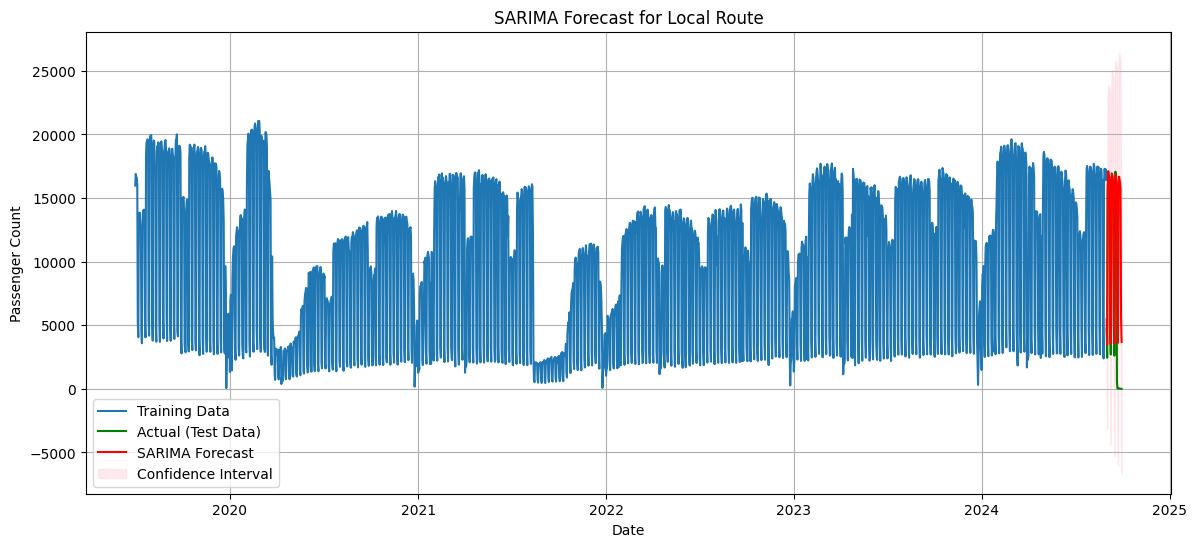

In [30]:
# PLOT FORECAST VS ACTUAL
plt.figure(figsize=(14, 6))

plt.plot(train.index, train, label="Training Data")
plt.plot(test.index, test, label="Actual (Test Data)", color="green")
plt.plot(test.index, forecast_mean, label="SARIMA Forecast", color="red")

plt.fill_between(
    test.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="pink",
    alpha=0.3,
    label="Confidence Interval"
)

plt.title(f"SARIMA Forecast for {service}")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# FUTURE FORECAST DAYS
future_days = 14     # <=== Change this value for longer-range forecasting

future_forecast = sarima_result.get_forecast(steps=future_days)
future_pred = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

print("\nNEXT 14-DAY FORECAST:")
print(future_pred)


NEXT 14-DAY FORECAST:
2024-08-31     5464.271430
2024-09-01     3448.783026
2024-09-02    16051.464984
2024-09-03    17118.501419
2024-09-04    16875.160657
2024-09-05    16657.020393
2024-09-06    16138.402580
2024-09-07     5556.034720
2024-09-08     3544.588206
2024-09-09    15878.008514
2024-09-10    16939.488962
2024-09-11    16726.248617
2024-09-12    16452.487282
2024-09-13    15986.232977
Freq: D, Name: predicted_mean, dtype: float64


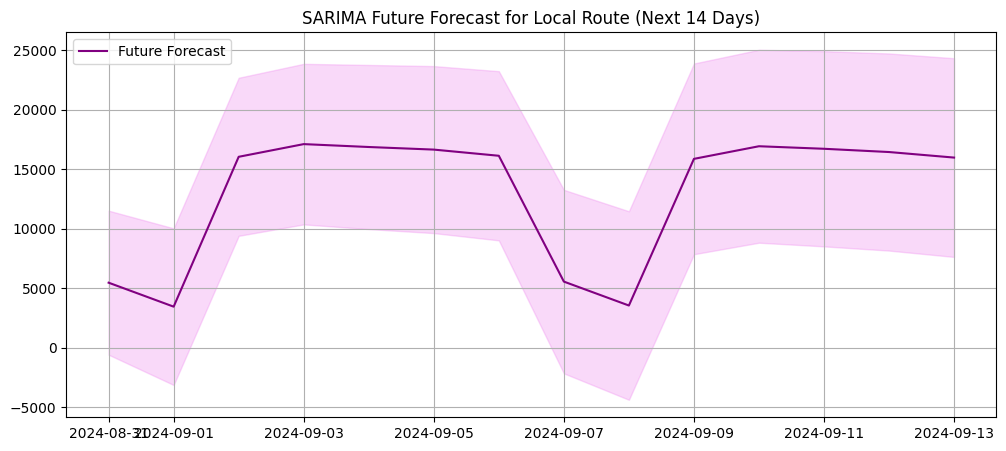

In [32]:
plt.figure(figsize=(12, 5))
plt.plot(future_pred.index, future_pred, label="Future Forecast", color="purple")
plt.fill_between(
    future_ci.index,
    future_ci.iloc[:, 0],
    future_ci.iloc[:, 1],
    alpha=0.3,
    color='violet'
)
plt.title(f"SARIMA Future Forecast for {service} (Next {future_days} Days)")
plt.grid(True)
plt.legend()
plt.show()